<a href="https://colab.research.google.com/github/shicks44/DS3000-Group-8/blob/main/Group_8_AI_detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
BASE_PATH = kagglehub.dataset_download('shreyasraghav/shutterstock-dataset-for-ai-vs-human-gen-image')

print('Data source import complete.')


Using Colab cache for faster access to the 'shutterstock-dataset-for-ai-vs-human-gen-image' dataset.
Data source import complete.


In [2]:

import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# image handler
from PIL import Image

# basic train and test matrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)

# py torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# optimisers and schedulers
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# torch vision transforms and such
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.models import resnet18,ResNet18_Weights
# progress bar for waiting
from tqdm.auto import tqdm

##DATA SET LOADING

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  79950 non-null  int64 
 1   file_name   79950 non-null  object
 2   label       79950 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB
None 

Missing values per column:
Unnamed: 0    0
file_name     0
label         0
dtype: int64 

Index(['file_name', 'label'], dtype='object')


/tmp/ipython-input-668034570.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=trainData, palette='viridis')


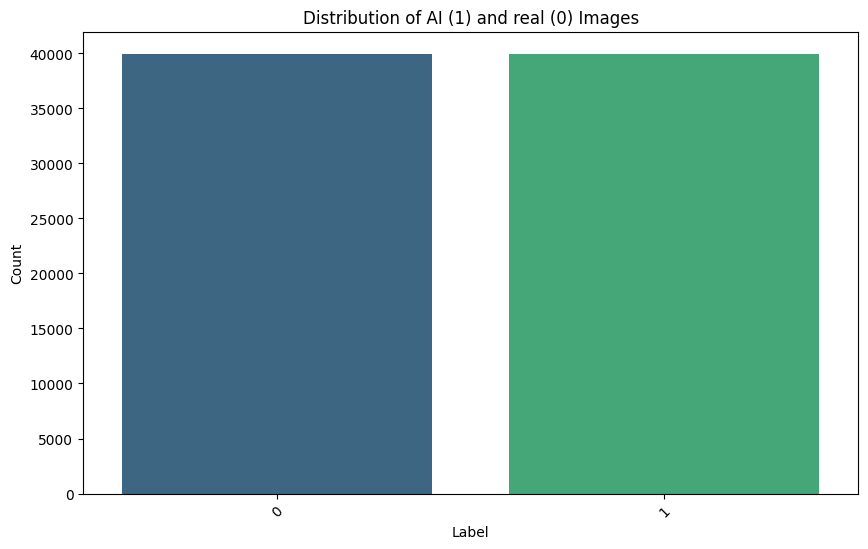

In [3]:

trainData = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
testData = pd.read_csv(os.path.join(BASE_PATH, "test.csv"))

trainData.head()

print("Dataset Info:")
print(trainData.info(), "\n")

print("Missing values per column:")
print(trainData.isnull().sum(), "\n")

if 'Unnamed: 0' in trainData.columns:
    trainData.drop(columns=['Unnamed: 0'], inplace=True)
print(trainData.columns)

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=trainData, palette='viridis')
plt.title('Distribution of AI (1) and real (0) Images')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

##DATA SET SPLIT
80% train 20% validation and the kaggle provided testing set

In [4]:
train_df, val_df = train_test_split(trainData, test_size=0.2,stratify=trainData["label"],random_state=42)

#stratify makes sure that the classifiers used are in even magnitudes.
# something like 20,000 AI 20,000 Real instead of 15,000 AI and 25,000 real

print("Training size: ", len(train_df))
print("Validation size: ", len(val_df))
print("Testing size: ", len(testData))

Training size:  63960
Validation size:  15990
Testing size:  19986


##IMAGE SIZING

In [5]:
train_tfms= T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tfms= T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

##DETECTOR CLASS

In [6]:
class AIDetectDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(BASE_PATH,row['file_name'])   # for train.csv
        # If you're using test.csv with 'id', use row['id'] instead

        img = Image.open(img_path).convert("RGB")

        if self.transforms:
            img = self.transforms(img)

        label = int(row["label"])   # 0 or 1
        return img, label

##DATA LOADERS

In [7]:
batch_size = 32

train_ds = AIDetectDataset(train_df, transforms=train_tfms)
val_ds   = AIDetectDataset(val_df,   transforms=val_tfms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

# quick sanity check
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape, "Labels sample:", labels[:8])


Batch shape: torch.Size([32, 3, 224, 224]) Labels sample: tensor([0, 1, 0, 1, 0, 1, 1, 1])


##DEFINING DEVICE (CPU OR GPU)

In [8]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load a ResNet18 pre-trained on ImageNet
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Replace the final fully connected layer to output 2 classes (0 = real, 1 = AI)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


##IMPLIMENTING RESNETS CNN MODEL

In [9]:
history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
best_val_loss = float("inf")
num_epochs = 5  # start small to test we will move to 15 when reaching a final product

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)              # shape [batch, 2]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validate
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total



    #save the history

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    if val_loss < best_val_loss:
      torch.save(model.state_dict(), "best_model.pth")
      best_val_loss = val_loss
      print(f"New best model saved (val_loss = {best_val_loss:.4f})")

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.4f}")


Epoch 1/5


  0%|          | 0/1999 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0422)
Train Loss: 0.0964  Train Acc: 0.9631
Val   Loss: 0.0422  Val   Acc: 0.9837

Epoch 2/5


  0%|          | 0/1999 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0374)
Train Loss: 0.0485  Train Acc: 0.9820
Val   Loss: 0.0374  Val   Acc: 0.9886

Epoch 3/5


  0%|          | 0/1999 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0296)
Train Loss: 0.0343  Train Acc: 0.9877
Val   Loss: 0.0296  Val   Acc: 0.9902

Epoch 4/5


  0%|          | 0/1999 [00:00<?, ?it/s]

Train Loss: 0.0291  Train Acc: 0.9893
Val   Loss: 0.0337  Val   Acc: 0.9882

Epoch 5/5


  0%|          | 0/1999 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0209)
Train Loss: 0.0228  Train Acc: 0.9918
Val   Loss: 0.0209  Val   Acc: 0.9924


##EVALUATION

Validation performance:
Accuracy : 0.9924
Precision: 0.9972
Recall   : 0.9875
F1-score : 0.9923

Classification report:
              precision    recall  f1-score   support

    Real (0)       0.99      1.00      0.99      7995
      AI (1)       1.00      0.99      0.99      7995

    accuracy                           0.99     15990
   macro avg       0.99      0.99      0.99     15990
weighted avg       0.99      0.99      0.99     15990



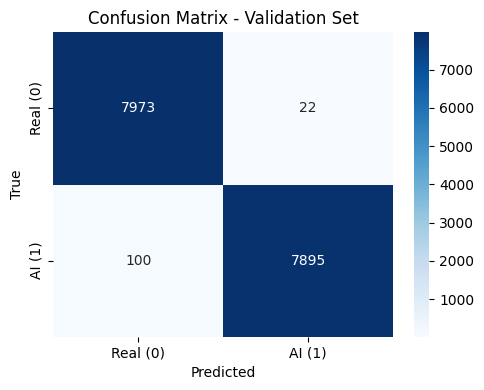

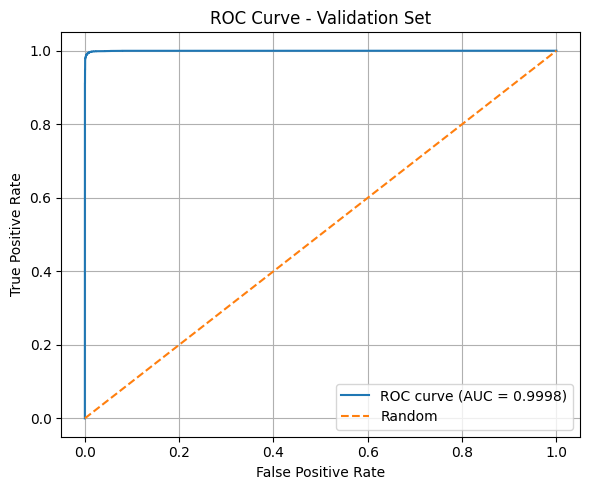

In [10]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

all_labels = []
all_preds = []
all_probs = []  # probability for class 1 (AI)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)           # logits [batch, 2]
        probs = torch.softmax(outputs, dim=1)[:, 1]  # P(class=1)

        _, preds = torch.max(outputs, 1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

# Concatenate all batches
all_labels = np.concatenate(all_labels)
all_preds  = np.concatenate(all_preds)
all_probs  = np.concatenate(all_probs)

# Metrics
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, pos_label=1)
rec  = recall_score(all_labels, all_preds, pos_label=1)
f1   = f1_score(all_labels, all_preds, pos_label=1)

print("Validation performance:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=["Real (0)", "AI (1)"]))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Real (0)", "AI (1)"],
            yticklabels=["Real (0)", "AI (1)"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

# ROC Curve + AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=1)
auc = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


###